In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import k0, iti0k0
import matplotlib.pyplot as plt
% matplotlib inline
from time import time
from new_struct.well import Well as NewWell

In [2]:
top_bound = "imp"
bottom_bound = "imp"
wtype = "frac"
n_stehf = 10
xwd = 2.5
xed = 5.
ywd = 2.5
yed = 5.
N = 20
Fcd = 10
new_well_nnnn = NewWell("nnnn", top_bound, bottom_bound, "frac", N, 1, [xwd], [ywd], x_lengths = 1,
                     xed = xed, yed = yed, attrs = {"Fcd":Fcd})
new_well_inf = NewWell("inf", top_bound, bottom_bound, "frac", N, 1, [0.], [0.], x_lengths = 1,
                     xed = xed, yed = yed, attrs = {"Fcd":Fcd})

### playing with new containers

In [3]:
_, xjs, xj1s, yws, _, _, _ = new_well_nnnn.lapl_well.matrixizer.raw

In [4]:
xjs = xjs[0,...]
xj1s = xj1s[0,...]
yws = yws[0,...]
xis = 3*np.ones_like(xjs)
yds = 3*np.ones_like(xjs)
buf_k = {"dyds_0":{}, "dyds_nnz":{}}
buf_fb_1_2 = {}

### test_calc

In [5]:
ts = np.logspace(-3, 1, 41)

In [6]:
p_inf_new = []
for t in ts:
    p_inf_new.append(new_well_inf.pw(t))

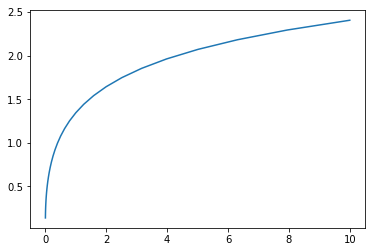

In [7]:
plt.plot(ts, p_inf_new)

In [8]:
t1 = time()
p_nnnn_new = []
for t in ts:
    p_nnnn_new.append(new_well_nnnn.pw(t))
print(time() - t1)

6.20735502243042


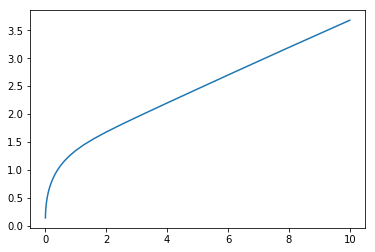

In [9]:
plt.plot(ts, p_nnnn_new)

In [18]:
yds = np.linspace(1, yed-1, 21)
xds = xwd*np.ones_like(yds)
t = 5
coords = np.vstack([xds, yds]).T
pxys = []
for xd, yd in coords:
    pxys.append(new_well_nnnn.pxy(t, xd, yd))

In [19]:
print(pxys[np.argwhere(coords[:,1]==ywd)[0,0]])
print(new_well_nnnn.pw(t))

2.4427003286
2.44878098657


In [20]:
yds_inf = np.linspace(-2, 2, 21)
xds_inf = np.zeros_like(yds_inf)
t = 5
coords_inf = np.vstack([xds_inf, yds_inf]).T
pxys_inf = []
for xd, yd in coords_inf:
    pxys_inf.append(new_well_inf.pxy(t, xd, yd))

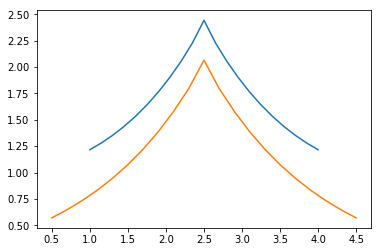

In [21]:
plt.plot(coords[:,1], pxys)
plt.plot(coords_inf[:,1]+ywd, pxys_inf)

In [14]:
from new_struct.integrators import frac_inf, frac_nnnn

In [18]:
u = 7
xd = 3
yd = 4
_, xjs_, xj1s_, yws_, _, zws_, zds_ = new_well_nnnn.lapl_well.matrixizer.raw
xjs = xjs_[0,...]
xj1s = xj1s_[0,...]
yws = yws_[0,...]
xis = xd*np.ones_like(xjs, dtype=np.float)
yds = yd*np.ones_like(xjs, dtype=np.float)
buf = {"dyds_0": {}, "dyds_nnz": {}}
m = frac_nnnn.integrate_matrix_(u, buf, buf, xed, yed, xis, xjs, xj1s, yws, yds, zws_, zds_)

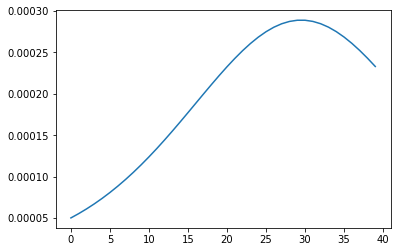

In [20]:
plt.plot(m)

In [22]:
del buf['dyds_0']

In [23]:
buf

{'dyds_nnz': {'-1+': (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
          34, 35, 36, 37, 38, 39], dtype=int32),
   array([[ 14.55,   0.05,   1.5 ],
          [ 14.6 ,   0.05,   1.5 ],
          [ 14.65,   0.05,   1.5 ],
          [ 14.7 ,   0.05,   1.5 ],
          [ 14.75,   0.05,   1.5 ],
          [ 14.8 ,   0.05,   1.5 ],
          [ 14.85,   0.05,   1.5 ],
          [ 14.9 ,   0.05,   1.5 ],
          [ 14.95,   0.05,   1.5 ],
          [ 15.  ,   0.05,   1.5 ],
          [ 15.05,   0.05,   1.5 ],
          [ 15.1 ,   0.05,   1.5 ],
          [ 15.15,   0.05,   1.5 ],
          [ 15.2 ,   0.05,   1.5 ],
          [ 15.25,   0.05,   1.5 ],
          [ 15.3 ,   0.05,   1.5 ],
          [ 15.35,   0.05,   1.5 ],
          [ 15.4 ,   0.05,   1.5 ],
          [ 15.45,   0.05,   1.5 ],
          [ 15.5 ,   0.05,   1.5 ],
          [ 15.55,   0.05,   1.5 ],
          [ 15.6 ,  

## Try to improve speed

In [12]:
# made dlm in fb2 - slightly improved speed from 6.18 to 4.63 s /41 pts

In [14]:
arg_x_0, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4 = new_well_nnnn.lapl_well.matrixizer.m_cache["fb_1_2_nnnn"]
u = 7

In [10]:
from new_struct.integrators.frac_nnnn import ifb2

In [11]:
from numba import jit

In [12]:
@jit(nopython=True)
def n_ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed, dlm = None):
    blk_size = 10
    MAXITER = 1000
    TINY = 1e-20
    EPS = 1e-12
    sum_ = np.zeros_like(arg_x_1)
    if dlm is None:
        dlm = 0.
    for i in range(MAXITER):
        blk = np.arange(1+i*blk_size, 1+(i+1)*blk_size)
        d = np.zeros_like(arg_x_1)
        for k in blk:
            d += ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
        sum_ += d
        if np.linalg.norm(d)/(np.linalg.norm(sum_)+ dlm + TINY) < EPS:
            return sum_
    return sum_

@jit(nopython=True)
def ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed):
    ek = (u + k*k*np.pi*np.pi/xed/xed)**0.5
    sexp = calc_sexp(ek, yed)
    p1 = 2./k/ek*np.cos(k*arg_x_1) # arg_x_1
    p1 *= np.sin(k*arg_x_2) # arg_x_2
    p1 *= np.cos(k*arg_x_3) # arg_x_3
    p1 *= (np.exp(-ek*arg_y_1) + np.exp(-ek*arg_y_2) + np.exp(-ek*arg_y_3))*(1 + sexp) + np.exp(-ek*arg_y_4)*sexp # arg_y_1, arg_y_2, arg_y3, arg_y_4
    return p1

@jit(nopython=True)
def calc_sexp(ek, yed):
    ek_ = ek*yed
    MAXITER = 300
    blk_size = 3
    TINY = 1e-20
    EPS = 1e-12
    sum_ = 0.
    for i in range(1, MAXITER):
        blk = np.arange(1+i*blk_size, 1+(i+1)*blk_size)
        d = np.sum(np.exp(-2*blk*ek_))
        sum_ += d
        if d/(sum_ + TINY) < EPS:
            return sum_
    return sum_
    #raise RuntimeWarning("calc_sexp did not converge in {} steps".format(MAXITER))

In [23]:
@jit(nopython=True)
def nn_ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed, dlm = None):
    blk_size = 10
    MAXITER = 1000
    TINY = 1e-20
    EPS = 1e-12
    sum_ = np.zeros_like(arg_x_1)
    if dlm is None:
        dlm = 0.
    for i in range(MAXITER):
        blk = np.arange(1+i*blk_size, 1+(i+1)*blk_size)
        d = np.zeros_like(arg_x_1)
        for k in blk:
            ek = (u + k*k*np.pi*np.pi/xed/xed)**0.5
            MAXITER_ = 300
            blk_size_ = 3
            TINY_ = 1e-20
            EPS_ = 1e-12
            sexp = 0.
            for j in range(1, MAXITER_):
                blk_ = np.arange(1+j*blk_size_, 1+(j+1)*blk_size_)
                d_ = np.sum(np.exp(-2*blk_*ek))
                sexp += d_
                if d_/(sexp + TINY_) < EPS_:
                    break
            p1 = 2./k/ek*np.cos(k*arg_x_1) # arg_x_1
            p1 *= np.sin(k*arg_x_2) # arg_x_2
            p1 *= np.cos(k*arg_x_3) # arg_x_3
            p1 *= (np.exp(-ek*arg_y_1) + np.exp(-ek*arg_y_2) + np.exp(-ek*arg_y_3))*(1 + sexp) + np.exp(-ek*arg_y_4)*sexp
            d += p1
        sum_ += d
        if np.linalg.norm(d)/(np.linalg.norm(sum_)+ dlm + TINY) < EPS:
            return sum_
    return sum_

In [34]:
u = 7
t1 = time()
for _ in range(1000):
    nn_ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
print(time() - t1)

15.771902322769165


In [35]:
t1 = time()
for _ in range(1000):
    ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
print(time() - t1)

18.195040702819824


## Try reimplement ifb2

In [11]:
def re_ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed, dlm = None, debug = False):
    blk_size = 10
    MAXITER = 1000
    TINY = 1e-20
    EPS = 1e-12
    sum_ = np.zeros_like(arg_x_1, dtype=np.float)
    if dlm is None:
        dlm = 0.
    for i in range(MAXITER):
        blk = np.arange(1+i*blk_size, 1+(i+1)*blk_size)
        d = None
        for k in blk:
            if d is None:
                d = re_ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
            else:
                d = np.dstack(
                    [d, re_ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)])
        d = np.sum(d, axis=-1)
        sum_ = np.sum(np.array([sum_, d], dtype=np.float), axis=0)
        if np.linalg.norm(d)/(np.linalg.norm(sum_)+ dlm + TINY) < EPS:
            if debug:
                return sum_, i*blk_size
            else:
                return sum_
    raise RuntimeWarning("ifb2 did not converge in {} steps".format(MAXITER))

def re_ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed):
    ek = (u + k*k*np.pi*np.pi/xed/xed)**0.5
    sexp = re_calc_sexp(ek, yed)
    p1 = 2./k/ek*np.cos(k*arg_x_1) # arg_x_1
    p1 *= np.sin(k*arg_x_2) # arg_x_2
    p1 *= np.cos(k*arg_x_3) # arg_x_3
    p1 *= (np.exp(-ek*arg_y_1) + np.exp(-ek*arg_y_2) + np.exp(-ek*arg_y_3))*(1 + sexp) + np.exp(-ek*arg_y_4)*sexp # arg_y_1, arg_y_2, arg_y3, arg_y_4
    return p1

def re_calc_sexp(ek, yed):
    ek_ = ek*yed
    MAXITER = 300
    blk_size = 3
    TINY = 1e-20
    EPS = 1e-12
    sum_ = 0.
    for i in range(1, MAXITER):
        blk = np.arange(1+i*blk_size, 1+(i+1)*blk_size)
        d = np.sum(np.exp(-2*blk*ek_))
        sum_ += d
        if d/(sum_ + TINY) < EPS:
            return sum_
    raise RuntimeWarning("calc_sexp did not converge in {} steps".format(MAXITER))

In [15]:
t1 = time()
for _ in range(1000):
    re_ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
print(time() - t1)

19.98114275932312


## Try Cython

In [36]:
%load_ext cython

In [39]:
%%cython
cimport numpy as np

def c_ifb2(u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed, dlm = None):
    blk_size = 10
    MAXITER = 1000
    TINY = 1e-20
    EPS = 1e-12
    sum_ = np.zeros_like(arg_x_1)
    if dlm is None:
        dlm = 0.
    for i in range(MAXITER):
        blk = np.arange(1+i*blk_size, 1+(i+1)*blk_size)
        d = np.zeros_like(arg_x_1)
        for k in blk:
            d += ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed)
        sum_ += d
        if np.linalg.norm(d)/(np.linalg.norm(sum_)+ dlm + TINY) < EPS:
            return sum_
    return sum_

def ifb2_k(k, u, arg_x_1, arg_x_2, arg_x_3, arg_y_1, arg_y_2, arg_y_3, arg_y_4, xed, yed):
    ek = (u + k*k*np.pi*np.pi/xed/xed)**0.5
    sexp = calc_sexp(ek, yed)
    p1 = 2./k/ek*np.cos(k*arg_x_1) # arg_x_1
    p1 *= np.sin(k*arg_x_2) # arg_x_2
    p1 *= np.cos(k*arg_x_3) # arg_x_3
    p1 *= (np.exp(-ek*arg_y_1) + np.exp(-ek*arg_y_2) + np.exp(-ek*arg_y_3))*(1 + sexp) + np.exp(-ek*arg_y_4)*sexp # arg_y_1, arg_y_2, arg_y3, arg_y_4
    return p1

def calc_sexp(ek, yed):
    ek_ = ek*yed
    MAXITER = 300
    blk_size = 3
    TINY = 1e-20
    EPS = 1e-12
    sum_ = 0.
    for i in range(1, MAXITER):
        blk = np.arange(1+i*blk_size, 1+(i+1)*blk_size)
        d = np.sum(np.exp(-2*blk*ek_))
        sum_ += d
        if d/(sum_ + TINY) < EPS:
            return sum_
    return sum_

DistutilsPlatformError: Unable to find vcvarsall.bat

In [3]:
from scipy.special import k0
from scipy.integrate import quad

In [5]:
def f(squ, xd, xwd, dyd):
    g = lambda t: k0(squ*((xd-xwd-t)**2 + dyd**2)**0.5)
    return quad(g, -1, 1)[0]

In [6]:
f(1, -1, 0, 1)

0.4990890378057079

In [15]:
def fw(squ, xdw, xwdw, dyd):
    g1 = lambda t: k0(squ*((xdw - xwdw - t)**2 + dyd**2)**0.5)
    return quad(g1, 0, 2)[0]

In [16]:
fw(1, 0, 0, 1)

0.4990890378057079

In [19]:
new_well_nnnn.lapl_well.sources_["sources_list"][0].xis

array([ 1.525,  1.575,  1.625,  1.675,  1.725,  1.775,  1.825,  1.875,
        1.925,  1.975,  2.025,  2.075,  2.125,  2.175,  2.225,  2.275,
        2.325,  2.375,  2.425,  2.475,  2.525,  2.575,  2.625,  2.675,
        2.725,  2.775,  2.825,  2.875,  2.925,  2.975,  3.025,  3.075,
        3.125,  3.175,  3.225,  3.275,  3.325,  3.375,  3.425,  3.475])

In [27]:
new_well_nnnn.lapl_well.sources_["sources_list"][0].xjs

array([ 1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,  1.8 ,  1.85,  1.9 ,
        1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,  2.25,  2.3 ,  2.35,
        2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,  2.7 ,  2.75,  2.8 ,
        2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,  3.15,  3.2 ,  3.25,
        3.3 ,  3.35,  3.4 ,  3.45])

In [20]:
new_well_nnnn.lapl_well.sources_["sources_list"][0].xwd

2.5

In [21]:
np.linspace(1,3,3)

array([ 1.,  2.,  3.])

In [25]:
xwd = 2.5
x0 = -1
x1 = 1
n = 20
dx = 1/n
xis = np.linspace(xwd+x0+0.5*dx, xwd+x1-0.5*dx, 2*n)
xjs = xis - 0.5*dx
xj1s = xis + 0.5*dx

In [26]:
print(xis)
print(xjs)
print(xj1s)

[ 1.525  1.575  1.625  1.675  1.725  1.775  1.825  1.875  1.925  1.975
  2.025  2.075  2.125  2.175  2.225  2.275  2.325  2.375  2.425  2.475
  2.525  2.575  2.625  2.675  2.725  2.775  2.825  2.875  2.925  2.975
  3.025  3.075  3.125  3.175  3.225  3.275  3.325  3.375  3.425  3.475]
[ 1.5   1.55  1.6   1.65  1.7   1.75  1.8   1.85  1.9   1.95  2.    2.05
  2.1   2.15  2.2   2.25  2.3   2.35  2.4   2.45  2.5   2.55  2.6   2.65
  2.7   2.75  2.8   2.85  2.9   2.95  3.    3.05  3.1   3.15  3.2   3.25
  3.3   3.35  3.4   3.45]
[ 1.55  1.6   1.65  1.7   1.75  1.8   1.85  1.9   1.95  2.    2.05  2.1
  2.15  2.2   2.25  2.3   2.35  2.4   2.45  2.5   2.55  2.6   2.65  2.7
  2.75  2.8   2.85  2.9   2.95  3.    3.05  3.1   3.15  3.2   3.25  3.3
  3.35  3.4   3.45  3.5 ]


In [30]:
xwd = 1.5
x0 = 0
x1 = 2
n = 20
dx = 1/n
xis = np.linspace(xwd+x0+0.5*dx, xwd+x1-0.5*dx, 2*n)
xjs = xis - 0.5*dx
xj1s = xis + 0.5*dx

In [31]:
print(xis)
print(xjs)
print(xj1s)

[ 1.525  1.575  1.625  1.675  1.725  1.775  1.825  1.875  1.925  1.975
  2.025  2.075  2.125  2.175  2.225  2.275  2.325  2.375  2.425  2.475
  2.525  2.575  2.625  2.675  2.725  2.775  2.825  2.875  2.925  2.975
  3.025  3.075  3.125  3.175  3.225  3.275  3.325  3.375  3.425  3.475]
[ 1.5   1.55  1.6   1.65  1.7   1.75  1.8   1.85  1.9   1.95  2.    2.05
  2.1   2.15  2.2   2.25  2.3   2.35  2.4   2.45  2.5   2.55  2.6   2.65
  2.7   2.75  2.8   2.85  2.9   2.95  3.    3.05  3.1   3.15  3.2   3.25
  3.3   3.35  3.4   3.45]
[ 1.55  1.6   1.65  1.7   1.75  1.8   1.85  1.9   1.95  2.    2.05  2.1
  2.15  2.2   2.25  2.3   2.35  2.4   2.45  2.5   2.55  2.6   2.65  2.7
  2.75  2.8   2.85  2.9   2.95  3.    3.05  3.1   3.15  3.2   3.25  3.3
  3.35  3.4   3.45  3.5 ]
